In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Download the MINSET dataset

In [36]:
from tensorflow.keras.datasets import mnist


In [37]:
(trainX, trainy), (testX, testy) = mnist.load_data()
print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testy.shape))

Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


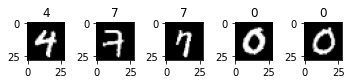

In [38]:
for j in range(5):
    i = np.random.randint(0, 10000)
    plt.subplot(550 + 1 + j)
    plt.imshow(trainX[i], cmap='gray')
    plt.title(trainy[i])
plt.show()

## Normalize the pixels values

In [39]:
train_data = trainX.astype('float32')/255
test_data = testX.astype('float32')/255
train_data = np.reshape(train_data, (60000, 28, 28, 1))
test_data = np.reshape(test_data, (10000, 28, 28, 1))
print (train_data.shape, test_data.shape)


(60000, 28, 28, 1) (10000, 28, 28, 1)


## Encoder 

In [40]:
import tensorflow

In [41]:
input_data = tensorflow.keras.layers.Input(shape=(28,28,1))
encoder = tensorflow.keras.layers.Conv2D(64, (5,5), activation='relu')(input_data)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)
encoder = tensorflow.keras.layers.Conv2D(64, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)
encoder = tensorflow.keras.layers.Conv2D(32, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)
encoder = tensorflow.keras.layers.Flatten()(encoder)
encoder = tensorflow.keras.layers.Dense(16)(encoder)

In [42]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tensorflow.shape(distribution_variance)[0]
    random = tensorflow.keras.backend.random_normal(shape=(batch_size, tensorflow.shape(distribution_variance)[1]))
    return distribution_mean + tensorflow.exp(0.5 * distribution_variance) * random
 
distribution_mean = tensorflow.keras.layers.Dense(2, name='mean')(encoder)
distribution_variance = tensorflow.keras.layers.Dense(2, name='log_variance')(encoder)
latent_encoding = tensorflow.keras.layers.Lambda(sample_latent_features)([distribution_mean, distribution_variance])

In [43]:
encoder_model = tensorflow.keras.Model(input_data, latent_encoding)
encoder_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 24, 24, 64)   1664        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 12, 12, 64)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 10, 10, 64)   36928       max_pooling2d_6[0][0]            
____________________________________________________________________________________________

## Decoder

In [44]:
decoder_input = tensorflow.keras.layers.Input(shape=(2))
decoder = tensorflow.keras.layers.Dense(64)(decoder_input)
decoder = tensorflow.keras.layers.Reshape((1, 1, 64))(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
 
decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)
 
decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)
 
decoder_output = tensorflow.keras.layers.Conv2DTranspose(1, (5,5), activation='relu')(decoder)

In [45]:
decoder_model = tensorflow.keras.Model(decoder_input, decoder_output)
decoder_model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                192       
_________________________________________________________________
reshape_2 (Reshape)          (None, 1, 1, 64)          0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 3, 3, 64)          36928     
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 5, 5, 64)          36928     
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 12, 12, 64)        3692

## VAE

In [46]:
encoded = encoder_model(input_data)
decoded = decoder_model(encoded)
autoencoder = tensorflow.keras.models.Model(input_data, decoded)
autoencoder.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model_6 (Functional)         (None, 2)                 57652     
_________________________________________________________________
model_7 (Functional)         (None, 28, 28, 1)         112577    
Total params: 170,229
Trainable params: 170,229
Non-trainable params: 0
_________________________________________________________________


## Loss Function

In [47]:
def get_loss(distribution_mean, distribution_variance):
    
    def get_reconstruction_loss(y_true, y_pred):
        reconstruction_loss = tensorflow.keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tensorflow.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch*28*28
    
    def get_k1_loss(distribution_mean, distribution_variance):
        k1_loss = 1 + distribution_variance - tensorflow.square(distribution_mean) - tensorflow.exp(distribution_variance)
        k1_loss_batch = tensorflow.reduce_mean(k1_loss)
        return k1_loss_batch*(-0.5)
    
    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
        k1_loss_batch = get_k1_loss(distribution_mean, distribution_variance)
        return reconstruction_loss_batch+k1_loss_batch
    return total_loss

In [48]:
autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance), optimizer='adam')


In [49]:
autoencoder.fit(train_data, train_data, epochs=20, batch_size=64, validation_data=(test_data, test_data))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 120s 2ms/sample - loss: 43.7255 - val_loss: 39.1174
Epoch 2/20
60000/60000 [==============================] - 147s 2ms/sample - loss: 38.3155 - val_loss: 37.9585
Epoch 3/20
60000/60000 [==============================] - 131s 2ms/sample - loss: 37.0767 - val_loss: 36.6231
Epoch 4/20
60000/60000 [==============================] - 131s 2ms/sample - loss: 36.3540 - val_loss: 35.9231
Epoch 5/20
60000/60000 [==============================] - 131s 2ms/sample - loss: 35.8672 - val_loss: 36.1854
Epoch 6/20
60000/60000 [==============================] - 129s 2ms/sample - loss: 35.5041 - val_loss: 35.6589
Epoch 7/20
60000/60000 [==============================] - 158s 3ms/sample - loss: 35.2684 - val_loss: 35.2466
Epoch 8/20
60000/60000 [==============================] - 136s 2ms/sample - loss: 35.0573 - val_loss: 35.2570
Epoch 9/20
60000/60000 [==============================] - 138s 2ms/sam

Real Test Images


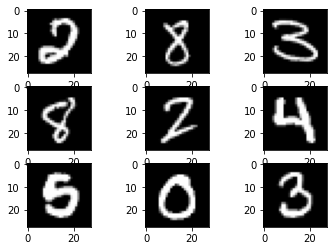

Reconstructed Images with Variational Autoencoder


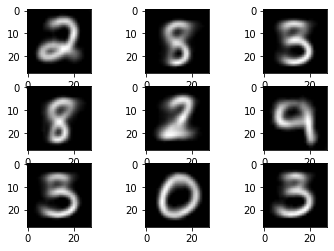

In [50]:
offset=400
print ("Real Test Images")
# Real Images
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(test_data[i+offset,:,:, -1], cmap='gray')
plt.show()
# Reconstructed Images
print ("Reconstructed Images with Variational Autoencoder")
for i in range(9):
    plt.subplot(330 + 1 + i)
    output = autoencoder.predict(np.array([test_data[i+offset]]))
    op_image = np.reshape(output[0]*255, (28, 28))
    plt.imshow(op_image, cmap='gray')
plt.show()

In [1]:
## Standard libraries
import os
import json
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial7"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

/var/folders/0r/n5_724tx3hs68r0rcbhyrtl80000gn/T/ipykernel_6050/3694070767.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Global seed set to 42


cpu


In [2]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial7/"
# Files to download
pretrained_files = ["NodeLevelMLP.ckpt", "NodeLevelGNN.ckpt", "GraphLevelGraphConv.ckpt"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [12]:
class GCNLayer(nn.Module):

    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = nn.Linear(c_in, c_out)

    def forward(self, node_feats, adj_matrix):
        """
        Inputs:
            node_feats - Tensor with node features of shape [batch_size, num_nodes, c_in]
            adj_matrix - Batch of adjacency matrices of the graph. If there is an edge from i to j, adj_matrix[b,i,j]=1 else 0.
                         Supports directed edges by non-symmetric matrices. Assumes to already have added the identity connections.
                         Shape: [batch_size, num_nodes, num_nodes]
        """
        # Num neighbours = number of incoming edges
        num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)
        node_feats = self.projection(node_feats)
        node_feats = torch.bmm(adj_matrix, node_feats)
        node_feats = node_feats / num_neighbours
        return node_feats

In [13]:
node_feats = torch.arange(8, dtype=torch.float32).view(1, 4, 2)
adj_matrix = torch.Tensor([[[1, 1, 0, 0],
                            [1, 1, 1, 1],
                            [0, 1, 1, 1],
                            [0, 1, 1, 1]]])

print("Node features:\n", node_feats)
print("\nAdjacency matrix:\n", adj_matrix)

Node features:
 tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])

Adjacency matrix:
 tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])


In [14]:
layer = GCNLayer(c_in=2, c_out=2)
layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0., 0.])

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)

print("Adjacency matrix", adj_matrix)
print("Input features", node_feats)
print("Output features", out_feats)

tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
Adjacency matrix tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
Input features tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
Output features tensor([[[1., 2.],
         [3., 4.],
         [4., 5.],
         [4., 5.]]])


In [6]:
class GATLayer(nn.Module):

    def __init__(self, c_in, c_out, num_heads=1, concat_heads=True, alpha=0.2):
        """
        Inputs:
            c_in - Dimensionality of input features
            c_out - Dimensionality of output features
            num_heads - Number of heads, i.e. attention mechanisms to apply in parallel. The
                        output features are equally split up over the heads if concat_heads=True.
            concat_heads - If True, the output of the different heads is concatenated instead of averaged.
            alpha - Negative slope of the LeakyReLU activation.
        """
        super().__init__()
        self.num_heads = num_heads
        self.concat_heads = concat_heads
        if self.concat_heads:
            assert c_out % num_heads == 0, "Number of output features must be a multiple of the count of heads."
            c_out = c_out // num_heads

        # Sub-modules and parameters needed in the layer
        self.projection = nn.Linear(c_in, c_out * num_heads)
        self.a = nn.Parameter(torch.Tensor(num_heads, 2 * c_out)) # One per head
        self.leakyrelu = nn.LeakyReLU(alpha)

        # Initialization from the original implementation
        nn.init.xavier_uniform_(self.projection.weight.data, gain=1.414)
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

    def forward(self, node_feats, adj_matrix, print_attn_probs=False):
        """
        Inputs:
            node_feats - Input features of the node. Shape: [batch_size, c_in]
            adj_matrix - Adjacency matrix including self-connections. Shape: [batch_size, num_nodes, num_nodes]
            print_attn_probs - If True, the attention weights are printed during the forward pass (for debugging purposes)
        """
        batch_size, num_nodes = node_feats.size(0), node_feats.size(1)

        # Apply linear layer and sort nodes by head
        node_feats = self.projection(node_feats)
        node_feats = node_feats.view(batch_size, num_nodes, self.num_heads, -1)

        # We need to calculate the attention logits for every edge in the adjacency matrix
        # Doing this on all possible combinations of nodes is very expensive
        # => Create a tensor of [W*h_i||W*h_j] with i and j being the indices of all edges
        edges = adj_matrix.nonzero(as_tuple=False) # Returns indices where the adjacency matrix is not 0 => edges
        node_feats_flat = node_feats.view(batch_size * num_nodes, self.num_heads, -1)
        edge_indices_row = edges[:,0] * num_nodes + edges[:,1]
        edge_indices_col = edges[:,0] * num_nodes + edges[:,2]
        a_input = torch.cat([
            torch.index_select(input=node_feats_flat, index=edge_indices_row, dim=0),
            torch.index_select(input=node_feats_flat, index=edge_indices_col, dim=0)
        ], dim=-1) # Index select returns a tensor with node_feats_flat being indexed at the desired positions along dim=0

        # Calculate attention MLP output (independent for each head)
        attn_logits = torch.einsum('bhc,hc->bh', a_input, self.a)
        attn_logits = self.leakyrelu(attn_logits)

        # Map list of attention values back into a matrix
        attn_matrix = attn_logits.new_zeros(adj_matrix.shape+(self.num_heads,)).fill_(-9e15)
        attn_matrix[adj_matrix[...,None].repeat(1,1,1,self.num_heads) == 1] = attn_logits.reshape(-1)

        # Weighted average of attention
        attn_probs = F.softmax(attn_matrix, dim=2)
        if print_attn_probs:
            print("Attention probs\n", attn_probs.permute(0, 3, 1, 2))
        node_feats = torch.einsum('bijh,bjhc->bihc', attn_probs, node_feats)

        # If heads should be concatenated, we can do this by reshaping. Otherwise, take mean
        if self.concat_heads:
            node_feats = node_feats.reshape(batch_size, num_nodes, -1)
        else:
            node_feats = node_feats.mean(dim=2)

        return node_feats

In [7]:
layer = GATLayer(2, 2, num_heads=2)
layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0., 0.])
layer.a.data = torch.Tensor([[-0.2, 0.3], [0.1, -0.1]])

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix, print_attn_probs=True)

print("Adjacency matrix", adj_matrix)
print("Input features", node_feats)
print("Output features", out_feats)

Attention probs
 tensor([[[[0.3543, 0.6457, 0.0000, 0.0000],
          [0.1096, 0.1450, 0.2642, 0.4813],
          [0.0000, 0.1858, 0.2885, 0.5257],
          [0.0000, 0.2391, 0.2696, 0.4913]],

         [[0.5100, 0.4900, 0.0000, 0.0000],
          [0.2975, 0.2436, 0.2340, 0.2249],
          [0.0000, 0.3838, 0.3142, 0.3019],
          [0.0000, 0.4018, 0.3289, 0.2693]]]])
Adjacency matrix tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
Input features tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
Output features tensor([[[1.2913, 1.9800],
         [4.2344, 3.7725],
         [4.6798, 4.8362],
         [4.5043, 4.7351]]])


In [16]:
import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data

In [17]:
gnn_layer_by_name = {
    "GCN": geom_nn.GCNConv,
    "GAT": geom_nn.GATConv,
    "GraphConv": geom_nn.GraphConv
}

## Node Level Application

In [18]:
cora_dataset = torch_geometric.datasets.Planetoid(root=DATASET_PATH, name="Cora")

Processing...
Done!


In [19]:
cora_dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [20]:
class GNNModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, num_layers=2, layer_name="GCN", dp_rate=0.1, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of the output features. Usually number of classes in classification
            num_layers - Number of "hidden" graph layers
            layer_name - String of the graph layer to use
            dp_rate - Dropout rate to apply throughout the network
            kwargs - Additional arguments for the graph layer (e.g. number of heads for GAT)
        """
        super().__init__()
        gnn_layer = gnn_layer_by_name[layer_name]

        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers-1):
            layers += [
                gnn_layer(in_channels=in_channels,
                          out_channels=out_channels,
                          **kwargs),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate)
            ]
            in_channels = c_hidden
        layers += [gnn_layer(in_channels=in_channels,
                             out_channels=c_out,
                             **kwargs)]
        self.layers = nn.ModuleList(layers)

    def forward(self, x, edge_index):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
        """
        for l in self.layers:
            # For graph layers, we need to add the "edge_index" tensor as additional input
            # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
            # we can simply check the class type.
            if isinstance(l, geom_nn.MessagePassing):
                x = l(x, edge_index)
            else:
                x = l(x)
        return x

In [21]:
class MLPModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, num_layers=2, dp_rate=0.1):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of the output features. Usually number of classes in classification
            num_layers - Number of hidden layers
            dp_rate - Dropout rate to apply throughout the network
        """
        super().__init__()
        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers-1):
            layers += [
                nn.Linear(in_channels, out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate)
            ]
            in_channels = c_hidden
        layers += [nn.Linear(in_channels, c_out)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x, *args, **kwargs):
        """
        Inputs:
            x - Input features per node
        """
        return self.layers(x)

In [92]:
class NodeLevelGNN(pl.LightningModule):

    def __init__(self, model_name, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        if model_name == "MLP":
            self.model = MLPModel(**model_kwargs)
        else:
            self.model = GNNModel(**model_kwargs)
        self.loss_module = nn.CrossEntropyLoss()

    def forward(self, data, mode="train"):
        x, edge_index = data.x, data.edge_index
        x = self.model(x, edge_index)

        # Only calculate the loss on the nodes corresponding to the mask
        if mode == "train":
            mask = data.train_mask
        elif mode == "val":
            mask = data.val_mask
        elif mode == "test":
            mask = data.test_mask
        else:
            assert False, f"Unknown forward mode: {mode}"

        loss = self.loss_module(x[mask], data.y[mask])
        acc = (x[mask].argmax(dim=-1) == data.y[mask]).sum().float() / mask.sum()
        return loss, acc

    def configure_optimizers(self):
        # We use SGD here, but Adam works as well
        optimizer = optim.SGD(self.parameters(), lr=0.1, momentum=0.9, weight_decay=2e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="train")
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="val")
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="test")
        self.log('test_acc', acc)
        
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.model(x)
        return y_hat

In [93]:
def train_node_classifier(model_name, dataset, **model_kwargs):
    pl.seed_everything(42)
    node_data_loader = geom_data.DataLoader(dataset, batch_size=1)

    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "NodeLevel" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         gpus=1 if str(device).startswith("cuda") else 0,
                         max_epochs=200,
                         progress_bar_refresh_rate=0) # 0 because epoch size is 1
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"NodeLevel{model_name}.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = NodeLevelGNN.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything()
        model = NodeLevelGNN(model_name=model_name, c_in=dataset.num_node_features, c_out=dataset.num_classes, **model_kwargs)
        trainer.fit(model, node_data_loader, node_data_loader)
        model = NodeLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on the test set
    test_result = trainer.test(model, test_dataloaders=node_data_loader, verbose=False)
    batch = next(iter(node_data_loader))
    batch = batch.to(model.device)
    _, train_acc = model.forward(batch, mode="train")
    _, val_acc = model.forward(batch, mode="val")
    result = {"train": train_acc,
              "val": val_acc,
              "test": test_result[0]['test_acc']}
    return model, result

In [94]:
# Small function for printing the test scores
def print_results(result_dict):
    if "train" in result_dict:
        print(f"Train accuracy: {(100.0*result_dict['train']):4.2f}%")
    if "val" in result_dict:
        print(f"Val accuracy:   {(100.0*result_dict['val']):4.2f}%")
    print(f"Test accuracy:  {(100.0*result_dict['test']):4.2f}%")

In [95]:
node_mlp_model, node_mlp_result = train_node_classifier(model_name="MLP",
                                                        dataset=cora_dataset,
                                                        c_hidden=16,
                                                        num_layers=2,
                                                        dp_rate=0.1)

print_results(node_mlp_result)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Found pretrained model, loading...
Train accuracy: 97.14%
Val accuracy:   54.60%
Test accuracy:  60.60%


In [144]:
node_gnn_model, node_gnn_result = train_node_classifier(model_name="GNN",
                                                        layer_name="GCN",
                                                        dataset=cora_dataset,
                                                        c_hidden=16,
                                                        num_layers=2,
                                                        dp_rate=0.1)
print_results(node_gnn_result)

Global seed set to 42
/Users/abanoubabdelmalak/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Found pretrained model, loading...
Train accuracy: 100.00%
Val accuracy:   78.60%
Test accuracy:  82.40%


/Users/abanoubabdelmalak/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
/Users/abanoubabdelmalak/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


In [227]:
#trainer = pl.Trainer()
#predictions = trainer.predict(node_gnn_model, cora_dataset.data)
print(type(cora_dataset[0]))
dataloader = geom_data.DataLoader(cora_dataset[0:1], batch_size=1)
ss = next(iter(dataloader))
print(dataloader.dataset)
#print(cora_dataset.data.x)
print(node_gnn_model(ss))

<class 'torch_geometric.data.data.Data'>
Cora()
(tensor(0.0587, grad_fn=<NllLossBackward0>), tensor(1.))


## Chemistry Level Example

In [148]:
tu_dataset = torch_geometric.datasets.TUDataset(root=DATASET_PATH, name="MUTAG")

Extracting ../data/MUTAG/MUTAG.zip
Processing...
Done!


In [207]:
print("Data object:", tu_dataset.data)
print("Length:", len(tu_dataset))
print(f"Average label: {tu_dataset.data.y.float().mean().item():4.2f}")


Data object: Data(x=[3371, 7], edge_index=[2, 7442], edge_attr=[7442, 4], y=[188])
Length: 188
Average label: 0.66


In [150]:
torch.manual_seed(42)
tu_dataset.shuffle()
train_dataset = tu_dataset[:150]
test_dataset = tu_dataset[150:]

In [177]:
graph_train_loader = geom_data.DataLoader(train_dataset, batch_size=64, shuffle=True)
graph_val_loader = geom_data.DataLoader(test_dataset, batch_size=64) # Additional loader if you want to change to a larger dataset
graph_test_loader = geom_data.DataLoader(test_dataset, batch_size=64)

In [196]:
batch = next(iter(graph_test_loader))
print("Batch:", batch)
print("Labels:", batch.y[:10])
print("Batch indices:", batch.batch[:40])

MUTAG(38)
Batch: DataBatch(edge_index=[2, 1512], x=[687, 7], edge_attr=[1512, 4], y=[38], batch=[687], ptr=[39])
Labels: tensor([1, 1, 1, 0, 0, 0, 1, 1, 1, 0])
Batch indices: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2])


In [153]:
class GraphGNNModel(nn.Module):
    def __init__(self, c_in, c_hidden, c_out, dp_rate_linear=0.5, **kwargs):
        super().__init__()
        self.GNN = GNNModel(c_in= c_in, c_hidden=c_hidden,
                           c_out=c_hidden,
                           **kwargs)
        self.head = nn.Sequential(
            nn.Dropout(dp_rate_linear),
            nn.Linear(c_hidden, c_out)
        )
        
    def forward(self, x, edge_index, batch_idx):
        x = self.GNN(x, edge_index)
        x = geom_nn.global_mean_pool(x, batch_idx) # Average pooling
        x = self.head(x)
        return x
    

In [154]:
class GraphLevelGNN(pl.LightningModule):

    def __init__(self, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        self.model = GraphGNNModel(**model_kwargs)
        self.loss_module = nn.BCEWithLogitsLoss() if self.hparams.c_out == 1 else nn.CrossEntropyLoss()

    def forward(self, data, mode="train"):
        x, edge_index, batch_idx = data.x, data.edge_index, data.batch
        x = self.model(x, edge_index, batch_idx)
        x = x.squeeze(dim=-1)

        if self.hparams.c_out == 1:
            preds = (x > 0).float()
            data.y = data.y.float()
        else:
            preds = x.argmax(dim=-1)
        loss = self.loss_module(x, data.y)
        acc = (preds == data.y).sum().float() / preds.shape[0]
        return loss, acc

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-2, weight_decay=0.0) # High lr because of small dataset and small model
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="train")
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="val")
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="test")
        self.log('test_acc', acc)

In [155]:
def train_graph_classifier(model_name, **model_kwargs):
    pl.seed_everything(42)

    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "GraphLevel" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         gpus=1 if str(device).startswith("cuda") else 0,
                         max_epochs=500,
                         progress_bar_refresh_rate=0)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"GraphLevel{model_name}.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = GraphLevelGNN.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)
        model = GraphLevelGNN(c_in=tu_dataset.num_node_features,
                              c_out=1 if tu_dataset.num_classes==2 else tu_dataset.num_classes,
                              **model_kwargs)
        trainer.fit(model, graph_train_loader, graph_val_loader)
        model = GraphLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    # Test best model on validation and test set
    train_result = trainer.test(model, test_dataloaders=graph_train_loader, verbose=False)
    test_result = trainer.test(model, test_dataloaders=graph_test_loader, verbose=False)
    result = {"test": test_result[0]['test_acc'], "train": train_result[0]['test_acc']}
    return model, result

In [159]:
model, result = train_graph_classifier(model_name="GraphConv",
                                       c_hidden=256,
                                       layer_name="GraphConv",
                                       num_layers=3,
                                       dp_rate_linear=0.5,
                                       dp_rate=0.0)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Found pretrained model, loading...


In [160]:
print(f"Train performance: {100.0*result['train']:4.2f}%")
print(f"Test performance:  {100.0*result['test']:4.2f}%")

Train performance: 93.28%
Test performance:  92.11%


In [218]:
batch = next(iter(graph_test_loader))
print(tu_dataset[0:1])
ssss = batch[0]
item = geom_data.DataLoader(tu_dataset[0:1], batch_size=1)
print(item.dataset)
item = next(iter(item))
print(item)
test_result = model(item)
print(test_result)

MUTAG(1)
MUTAG(1)
DataBatch(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1], batch=[17], ptr=[2])
(tensor(0.0007, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), tensor(1.))


In [1]:
from torch_geometric.datasets import QM9

In [2]:
dataset = QM9("qm9/")

In [79]:
print(dataset.data)

Data(x=[2359210, 11], edge_index=[2, 4883516], edge_attr=[4883516, 4], y=[130831, 19], pos=[2359210, 3], idx=[130831], name=[130831], z=[2359210])


In [26]:
print(dataset.data.y[0])

tensor([    0.0000,    13.2100,   -10.5499,     3.1865,    13.7363,    35.3641,
            1.2177, -1101.4878, -1101.4098, -1101.3840, -1102.0229,     6.4690,
          -17.1722,   -17.2868,   -17.3897,   -16.1519,   157.7118,   157.7100,
          157.7070])


In [32]:
print(dataset.data.x[0])

tensor([0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 4.])


In [42]:
print(dataset.data.edge_attr)

tensor(3) tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])


## A quick take on the Graph Autoencoder from https://github.com/Flawless1202

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn.models import InnerProductDecoder, VGAE
from torch_geometric.nn.conv import GCNConv
from torch_geometric.utils import negative_sampling, remove_self_loops, add_self_loops


class GCNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.gcn_shared = GCNConv(in_channels, hidden_channels)
        self.gcn_mu = GCNConv(hidden_channels, out_channels)
        self.gcn_logvar = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.gcn_shared(x, edge_index))
        mu = self.gcn_mu(x, edge_index)
        logvar = self.gcn_logvar(x, edge_index)
        return mu, logvar


class DeepVGAE(VGAE):
    def __init__(self, enc_in_channels, enc_hidden_channels, enc_out_channels):
        super(DeepVGAE, self).__init__(encoder=GCNEncoder(enc_in_channels,
                                                          enc_hidden_channels,
                                                          enc_out_channels),
                                       decoder=InnerProductDecoder())

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        adj_pred = self.decoder.forward_all(z)
        print(adj_pred)
        return adj_pred

    def loss(self, x, pos_edge_index, all_edge_index):
        z = self.encode(x, pos_edge_index)

        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index, sigmoid=True) + 1e-15).mean()

        # Do not include self-loops in negative samples
        all_edge_index_tmp, _ = remove_self_loops(all_edge_index)
        all_edge_index_tmp, _ = add_self_loops(all_edge_index_tmp)

        neg_edge_index = negative_sampling(all_edge_index_tmp, z.size(0), pos_edge_index.size(1))
        neg_loss = -torch.log(1 - self.decoder(z, neg_edge_index, sigmoid=True) + 1e-15).mean()

        kl_loss = 1 / x.size(0) * self.kl_loss()

        return pos_loss + neg_loss + kl_loss

    def single_test(self, x, train_pos_edge_index, test_pos_edge_index, test_neg_edge_index):
        with torch.no_grad():
            z = self.encode(x, train_pos_edge_index)
        roc_auc_score, average_precision_score = self.test(z, test_pos_edge_index, test_neg_edge_index)
        return roc_auc_score, average_precision_score

In [4]:
import os

import torch
import torch.nn as nn
from torch.optim import Adam

from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.utils import train_test_split_edges

#from model import DeepVGAE
#from config.config import parse_args

torch.manual_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#args = parse_args()

model = DeepVGAE(11, 22,2).to(device)
optimizer = Adam(model.parameters(), 0.1)

#os.makedirs("datasets", exist_ok=True)
#dataset = Planetoid("datasets", args.dataset, transform=T.NormalizeFeatures())
print(type(dataset[:2000].data))
data = dataset.data.to(device)
print(type(data))
all_edge_index = data.edge_index
print(all_edge_index)
#data = train_test_split_edges(data, 0.3, 0.01)
print(data.test_pos_edge_index)
for epoch in range(5):
    model.train()
    optimizer.zero_grad()
    loss = model.loss(data.x, data.train_pos_edge_index, all_edge_index)
    loss.backward()
    optimizer.step()
    print(epoch)
    if epoch % 2 == 0:
        model.eval()
        roc_auc, ap = model(data.x, data.edge_index)
        print("Epoch {} - Loss: {} ROC_AUC: {} Precision: {}".format(epoch, loss.cpu().item(), roc_auc, ap))


<class 'torch_geometric.data.data.Data'>
<class 'torch_geometric.data.data.Data'>
tensor([[ 0,  0,  0,  ..., 13, 14, 15],
        [ 1,  2,  3,  ...,  4,  7,  8]])


AttributeError: 'GlobalStorage' object has no attribute 'test_pos_edge_index'

## My Own VAE

In [2]:
from torch_geometric.datasets import QM9
dataset = QM9("qm9/")
print(dataset[10000])


Data(x=[16, 11], edge_index=[2, 30], edge_attr=[30, 4], y=[1, 19], pos=[16, 3], idx=[1], name='gdb_10277', z=[16])


In [118]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data
from torch_geometric.nn.models import InnerProductDecoder, VGAE
import torch_geometric.nn.models as mo
from torch_geometric.nn.conv import GCNConv
from torch_geometric.utils import negative_sampling, remove_self_loops, add_self_loops
import os
from torch_geometric.nn import GAE
import torch
import torch.nn as nn
from torch.optim import Adam
from torch import normal
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.utils import train_test_split_edges
from torch import normal
from torch_geometric.transforms import NormalizeFeatures,NormalizeRotation, NormalizeScale

In [162]:
from torch_geometric.datasets import QM9
dataset = QM9("qm9/")
#NormalizeFeatures(dataset.pos)
print(dataset)
loader = geom_data.DataLoader(dataset, batch_size=100, shuffle=True)
f = dataset[100000]
print(f.pos)
print(dataset[4].edge_attr)

QM9(130831)
tensor([[ 0.9480,  0.4268,  0.0734],
        [-0.0549, -0.6076, -0.4351],
        [-1.4190, -0.3698,  0.0597],
        [-2.4386, -0.1229, -0.8377],
        [-3.6669, -0.2564, -0.5288],
        [-1.7129, -0.7007,  1.3875],
        [-0.9021, -1.4030,  2.0738],
        [-2.9406, -0.0633,  2.0248],
        [-3.4241, -0.5304,  3.0240],
        [ 1.9415,  0.2097, -0.3303],
        [ 0.6646,  1.4375, -0.2364],
        [ 1.0111,  0.3970,  1.1632],
        [-0.0997, -0.5949, -1.5274],
        [ 0.2475, -1.6113, -0.1252],
        [-2.0638,  0.1893, -1.8178],
        [-4.2757,  0.0249, -1.2926],
        [-1.2880, -1.5019,  3.0158],
        [-3.2769,  0.8920,  1.5913]])
tensor([[0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]])


/Users/abanoubabdelmalak/opt/anaconda3/lib/python3.9/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [6]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)




In [7]:
class DeepVGAE(VGAE):
    def __init__(self, enc_in_channels,  enc_out_channels):
        super(DeepVGAE, self).__init__(encoder=GCNEncoder(enc_in_channels,
                                                          enc_out_channels),
                                       decoder=mo.InnerProductDecoder())

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        adj_pred = self.decoder.forward_all(z)
        return adj_pred
    
    def loss(self, batch):
        z = self.encode(batch.x, batch.edge_index)

        pos_loss = -torch.log(
            self.decoder(z, batch.edge_index, sigmoid=True) + 1e-15).mean()

        
        kl_loss = 1 / x.size(0) * self.kl_loss()

        return pos_loss + kl_loss
    


In [ ]:
class GCNModelVAE(nn.Module):
    def __init__(self, input_feat_dim, hidden_dim1, hidden_dim2, dropout):
        super(GCNModelVAE, self).__init__()
        self.gc1 = GraphConvolution(input_feat_dim, hidden_dim1, dropout, act=F.relu)
        self.gc2 = GraphConvolution(hidden_dim1, hidden_dim2, dropout, act=lambda x: x)
        self.gc3 = GraphConvolution(hidden_dim1, hidden_dim2, dropout, act=lambda x: x)
        self.dc = InnerProductDecoder(dropout, act=lambda x: x)

    def encode(self, x, adj):
        hidden1 = self.gc1(x, adj)
        return self.gc2(hidden1, adj), self.gc3(hidden1, adj)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x, adj):
        mu, logvar = self.encode(x, adj)
        z = self.reparameterize(mu, logvar)
        return self.dc(z), mu, logvar


class InnerProductDecoder(nn.Module):
    """Decoder for using inner product for prediction."""

    def __init__(self, dropout, act=torch.sigmoid):
        super(InnerProductDecoder, self).__init__()
        self.dropout = dropout
        self.act = act

    def forward(self, z):
        z = F.dropout(z, self.dropout, training=self.training)
        adj = self.act(torch.mm(z, z.t()))
        return adj

## Training 

In [8]:
def train_graph(model, **model_kwargs):
    pl.seed_everything(42)

    # Create a PyTorch Lightning trainer with the generation callback
    #root_dir = os.path.join(CHECKPOINT_PATH, "GraphLevel" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         gpus=1 if str(device).startswith("cuda") else 0,
                         max_epochs=500,
                         progress_bar_refresh_rate=0)
    #trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    #pretrained_filename = os.path.join(CHECKPOINT_PATH, f"GraphLevel{model_name}.ckpt")
    #if os.path.isfile(pretrained_filename):
    #    print("Found pretrained model, loading...")
    #    model = GraphLevelGNN.load_from_checkpoint(pretrained_filename)
    #else:
    trainer.fit(model, graph_train_loader, graph_val_loader)
    
    # Test best model on validation and test set
    train_result = trainer.test(model, test_dataloaders=graph_train_loader, verbose=False)
    test_result = trainer.test(model, test_dataloaders=graph_test_loader, verbose=False)
    result = {"test": test_result[0]['test_acc'], "train": train_result[0]['test_acc']}
    return model, result

def train(x, edge_index, model):
    model.train()
    
    optimizer.zero_grad()
    Adj = model(x, edge_index)
    mu, var = model.encoder.forward(x, edge_index)
    z = normal(mu, var**2)
    zz = model.encode(x, edge_index)
    x_hat = model.decoder.forward_all(z)
    loss = model.recon_loss(zz, edge_index)
    
    loss = loss + (1 / list(x.shape)[0]) * model.kl_loss()  # new line
    loss.backward()
    optimizer.step()
    #print(loss)
    
    return model, float(loss), zz

In [9]:

out_channels = 2
num_features = dataset.num_features
epochs = 300
validate_loader = geom_data.DataLoader(dataset[150:200], batch_size=64, shuffle=True) 
train_loader = geom_data.DataLoader(dataset[0:3000], batch_size=100, shuffle=True)

In [10]:
model = DeepVGAE(enc_in_channels = 3, enc_out_channels=4) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = Adam(model.parameters(), 0.01)
item = next(iter(train_loader))
print(model)
x = item.x
edge_index = item.edge_index
#print(train())
print(list(model.encode(item.pos, item.edge_index).shape))
#train(20)

DeepVGAE(
  (encoder): GCNEncoder(
    (conv1): GCNConv(3, 8)
    (conv_mu): GCNConv(8, 4)
    (conv_logstd): GCNConv(8, 4)
  )
  (decoder): InnerProductDecoder()
)
[1435, 4]


In [11]:
for epoch in range(1, 4):
    for batch in loader:
        x = batch.pos
        edge_index = batch.edge_index
        model, loss, z = train(x, edge_index, model)
    print('Epoch: {:03d}, Train_Loss: {:.4f}'.format(epoch, loss))
    
    
    #writer.add_scalar('auc train',auc,epoch) # new line
    #writer.add_scalar('ap train',ap,epoch)   # new line

Epoch: 001, Train_Loss: 1.0036
Epoch: 002, Train_Loss: 1.0377
Epoch: 003, Train_Loss: 1.0407


In [12]:
# torch.save(model.state_dict(), "model_1")

In [13]:
f = dataset[9]
print(model.decoder.forward_all(model.encode(f.pos,f.edge_index)))
print(model(f.pos, f.edge_index))
print(f.x)
print(f.pos)
print(f.edge_index)

tensor([[0.9778, 0.8436, 0.7898, 0.8519, 0.8697, 0.8566],
        [0.8436, 0.7975, 0.8085, 0.5939, 0.6304, 0.5929],
        [0.7898, 0.8085, 0.8367, 0.5146, 0.5621, 0.5135],
        [0.8519, 0.5939, 0.5146, 0.7507, 0.7429, 0.7495],
        [0.8697, 0.6304, 0.5621, 0.7429, 0.7603, 0.7552],
        [0.8566, 0.5929, 0.5135, 0.7495, 0.7552, 0.7573]],
       grad_fn=<SigmoidBackward0>)
tensor([[0.9805, 0.8513, 0.7660, 0.8440, 0.8790, 0.8636],
        [0.8513, 0.8151, 0.8039, 0.5565, 0.6214, 0.5905],
        [0.7660, 0.8039, 0.8140, 0.4657, 0.5195, 0.4935],
        [0.8440, 0.5565, 0.4657, 0.7575, 0.7559, 0.7558],
        [0.8790, 0.6214, 0.5195, 0.7559, 0.7894, 0.7730],
        [0.8636, 0.5905, 0.4935, 0.7558, 0.7730, 0.7650]],
       grad_fn=<SigmoidBackward0>)
tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 3.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 7., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0.,

## 

In [114]:
import numpy as np
print(list(np.array(f.pos)[3]))
print(np.array(f.pos))

[1.002, 1.8609, 0.0025]
[[-1.7900e-02  1.4671e+00  1.0100e-02]
 [ 1.7000e-03  1.0400e-02  2.1000e-03]
 [ 1.7700e-02 -1.1445e+00 -4.2000e-03]
 [ 1.0020e+00  1.8609e+00  2.5000e-03]
 [-5.4400e-01  1.8448e+00 -8.7080e-01]
 [-5.2710e-01  1.8352e+00  9.0490e-01]]


In [172]:
from sklearn.preprocessing import scale
x = np.array([[0,0,0]])
for i in dataset:
    a = np.array(i.pos)
    x = np.append(x, np.array(i.pos))
    print('1')
print(a)
print(x.shape)
dict = {}
for mol in dataset:
    z = np.array(mol.z)
    pos = np.array(mol.pos)
    for atom, pos in zip(z, pos):
        if str(atom) in dict:
            dict[str(atom)].append(pos)
        else:
            dict[str(atom)] = list()
            dict[str(atom)].append(pos)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


KeyboardInterrupt: 

In [59]:
print(dict['6'][6][2])

0.002


In [154]:
print(dict.keys())
print(np.array(dict['1'])[10000, 1:3])

dict_keys(['6', '1', '7', '8', '9'])
[2.0142 0.963 ]


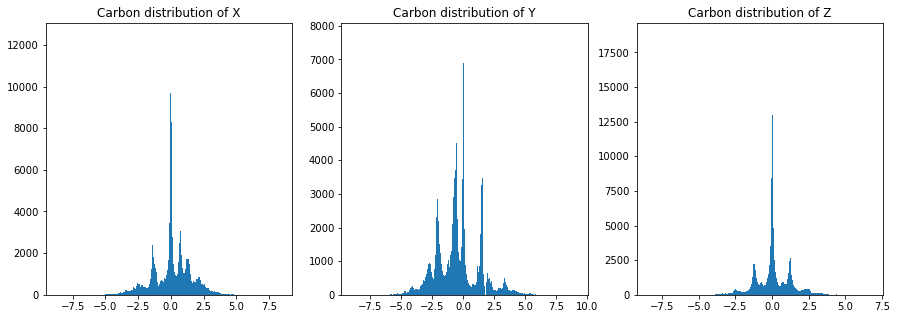

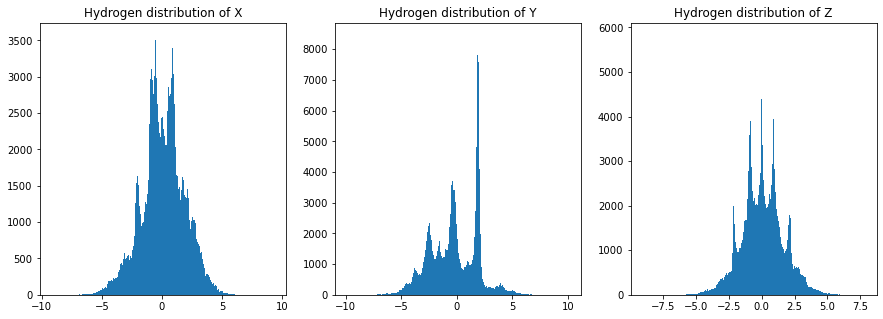

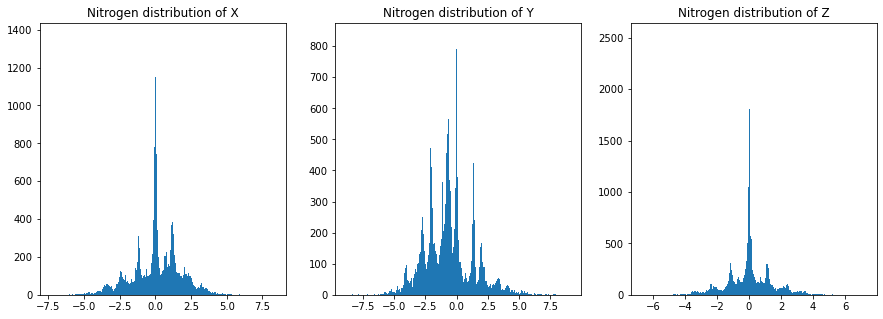

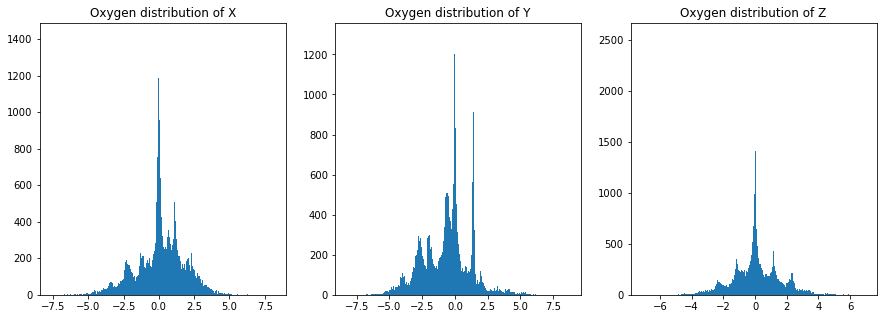

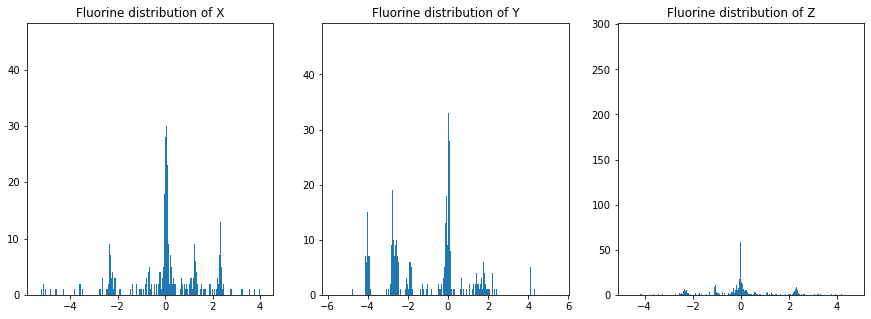

In [136]:
import matplotlib.pyplot as plt
cartesian = {'0':'X', '1':'Y', '2':'Z' }
atoms = {'1':'Hydrogen', '6':'Carbon', '7':'Nitrogen','8':'Oxygen','9':'Fluorine' }
colours = {'1':'b', '6':'r', '7':'k','8':'g','9':'y' }
for element in dict.keys():
    plt.figure(figsize=(15,5))
    for i in range(3):
        plt.subplot(1,3,i+1)
        #plt.plot(np.array(dict[element])[:,i],np.array(dict[element])[:,i+1],'o')
        plt.hist(np.array(dict[element])[:,i], bins=2000)
        plt.title(f'{atoms[element]} distribution of {cartesian[str(i)]}')
        
    plt.show()

In [148]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10**(10000)

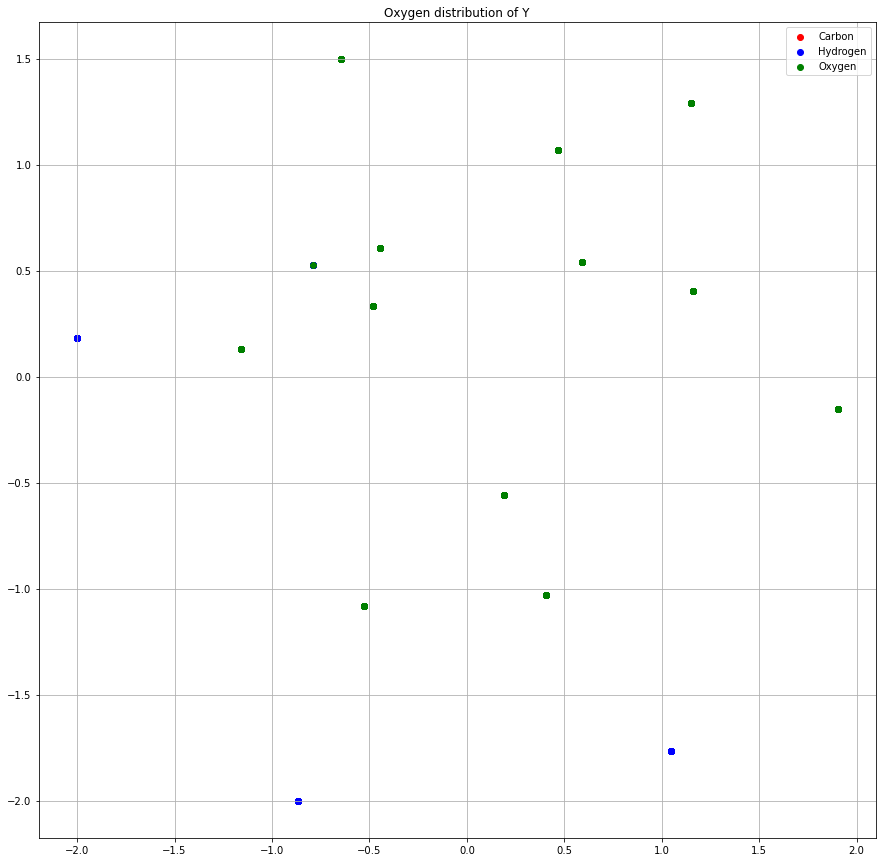

In [158]:
plt.figure(figsize=(15,15))

for element in dict.keys():
    if element in ['1','6','8']:
        for i in range(1,2):
            #plt.subplot(1,3,i+1)
            plt.scatter(np.array(dict[element])[:,i],np.array(dict[element])[:,i+1], color=colours[element],label =atoms[element] )
            #plt.hist(np.array(dict[element])[:,i], bins=2000)
            plt.title(f'{atoms[element]} distribution of {cartesian[str(i)]}')
plt.grid()
plt.legend()
plt.show()